<a href="https://colab.research.google.com/github/konan-91/OcularClassification/blob/master/notebooks/2_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Model

We now have four folders of topoplot images (which you should zip into *img_data.zip*) that will be used to train our model. We will utilise the fast.ai library - a deep learning library built ontop of PyTorch that provides high level abstractions for model training.

In [1]:
import os
from fastai.vision.all import *
from fastai.vision.widgets import *
from PIL import Image

In [2]:
!unzip -q /content/drive/MyDrive/diss/img_data.zip

As our model's purpose is to classify blinks, we should split our data into positive and negative examples. However, we should ensure each cateogry is roughly the same size. We will use the entirety of the img_blinks dataset, and sample from img_rest, h_saccades, and v_saccades using a 50/25/25 split.

In [5]:
def count_files(path):
    count = 0
    for img in os.listdir(path):
        count += 1
    return count

n_blinks = count_files('/content/img_data/img_blinks')
n_v_saccades = count_files('/content/img_data/img_v_saccades')
n_h_saccades = count_files('/content/img_data/img_h_saccades')
n_rest = count_files('/content/img_data/img_rest')

print(f'Number of blinks: {n_blinks}')
print(f'Number of vertical saccades: {n_v_saccades}')
print(f'Number of horizontal saccades: {n_h_saccades}')
print(f'Number of rest: {n_rest}')

Number of blinks: 4562
Number of vertical saccades: 1520
Number of horizontal saccades: 1520
Number of rest: 1520


After deleting excess files the positive and negative datasets are now equal. You can verify by running count_files() once more.

In [4]:
def delete_excess_files(path, idx):
    for img in os.listdir(path)[idx:]:
        os.remove(os.path.join(path, img))

paths = ['/content/img_data/img_rest', '/content/img_data/img_v_saccades', '/content/img_data/img_h_saccades']

for path in paths:
    delete_excess_files(path, n_blinks//3)

Reorganise directories so that DataLoaders works and labels are correct etc etc....

In [6]:
# Rename so that classification labels are correct
os.rename('/content/img_data/img_blinks', '/content/img_data/blink')
os.mkdir('/content/img_data/non-blink')

# Move all three to non-blink folder
for img in os.listdir('/content/img_data/img_rest'):
    os.rename(os.path.join('/content/img_data/img_rest', img), os.path.join('/content/img_data/non-blink', img))

for img in os.listdir('/content/img_data/img_v_saccades'):
    os.rename(os.path.join('/content/img_data/img_v_saccades', img), os.path.join('/content/img_data/non-blink', img))

for img in os.listdir('/content/img_data/img_h_saccades'):
    os.rename(os.path.join('/content/img_data/img_h_saccades', img), os.path.join('/content/img_data/non-blink', img))

In [7]:
!rm -r '/content/img_data/img_rest'
!rm -r '/content/img_data/img_v_saccades'
!rm -r '/content/img_data/img_h_saccades'

Version without saccades - blinks vs rest only

In [ ]:
# Rename so that classification labels are correct - do not run if above was run.
os.rename('/content/img_data/img_blinks', '/content/img_data/blink')
os.rename('/content/img_data/img_rest', '/content/img_data/non-blink')

# DataLoaders and Model Training

...

In [24]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=91),
    get_y=parent_label,
    item_tfms=CropPad(150)
)

In [25]:
dls = dblock.dataloaders('/content/img_data', bs=16)

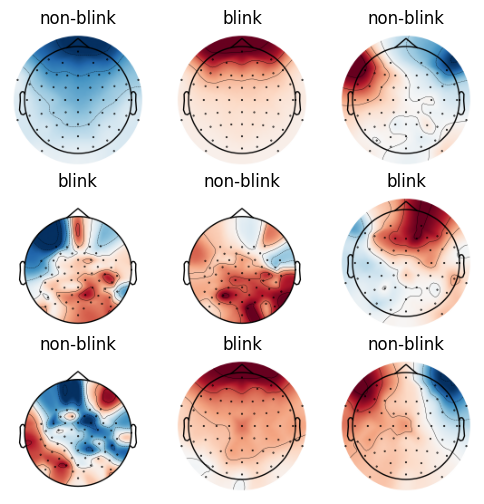

In [26]:
dls.show_batch(max_n=9, figsize=(6,6))

In [27]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(4)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.548672,0.532523,0.792971,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.421681,0.366787,0.819879,00:37
1,0.375005,0.328844,0.839649,00:37
2,0.317445,0.344767,0.835805,00:40
3,0.234782,0.353955,0.841845,00:36


In [29]:
interp.print_classification_report()

epoch,train_loss,valid_loss,accuracy,time


              precision    recall  f1-score   support

       blink       0.85      0.85      0.85       944
   non-blink       0.84      0.84      0.84       880

    accuracy                           0.85      1824
   macro avg       0.85      0.85      0.85      1824
weighted avg       0.85      0.85      0.85      1824



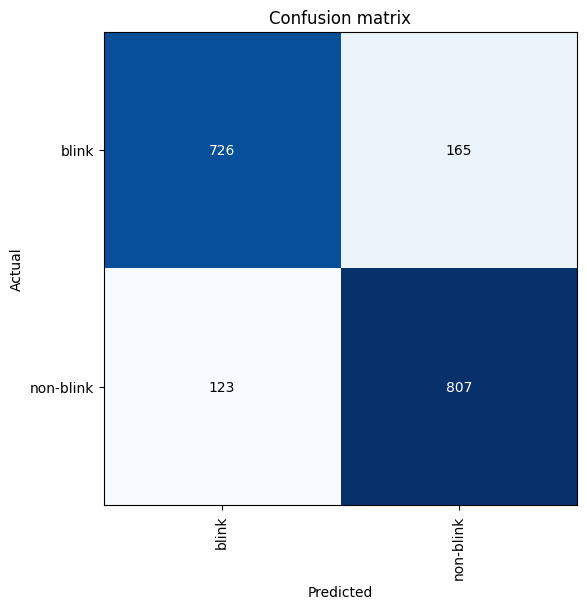

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

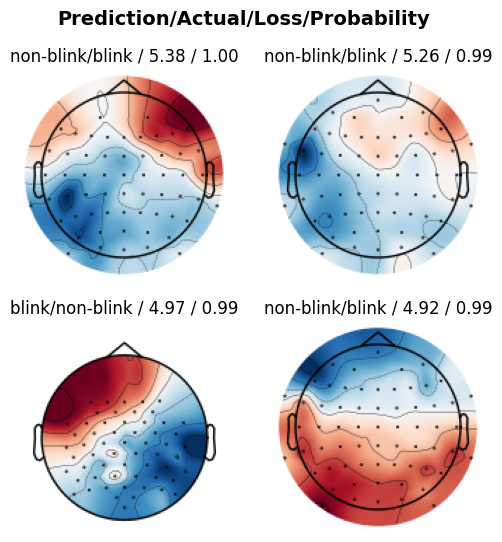

In [17]:
interp.plot_top_losses(k=4, figsize=(6, 6))

Above, we have plotted the "top losses" - these are the predictions the model made which were the *most incorrect*. In many cases, this is because there was a problem with the training data. We can now manually inspect these cases and remove any egregious errors. These are usually easy to spot, as blinks tend to be symmetrical and concentrated entirely at the front of the head, whereas saccades are asymmetrical, and the rest data will not show any discernable pattern.

After cleaning the data, we will re-train the model on our cleaned dataset.

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
# Removing the plots marked for deletion
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

All that's left is to export the model as a .pkl file so that we can use it to make predictions later on. Once trained, models work like functions and can be easily inserted into a program or data pipeline. They are also far less computationally expensive to use than to train, so they are quite convenient once exported. Ours is around 80mb.

In [28]:
learn.export('ocular_classifier.pkl')

# Iteration One

The first iteration of our model has an accuracy of ~85% on the validation data. Validation loss is ~0.3, which suggests the model is not entirely confident in it's predictions, even when it is correct.

Furthermore, 88% of blinks were correctly identified, whereas 77% of non-blinks were correctly identified. This makes sense, as half the training data are blinks, and the blinks are largely homogenous, with heavy frontal activity. Therefore, blinks are unlikely to be incorrectly classified. However, some saccades may look similar to blinks, and because of the strong representation the model holds for blinks this similarity may cause it to predict 'blink' for 'non-blink' saccades more often than the reverse.